In [214]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
plt.viridis()

import astropy.io.fits

import psrchive

import pipe

import residuals
import polycos

In [253]:
test_file = "/psr_archive/hessels/archibald/0337+17/raw/GBT/guppi_56050_0337+17_0008.forTOAs"


In [254]:
def pam_load(args,filename):
    with tempfile.TemporaryDirectory() as td:
        pipe.check_call(["pam", "-u", td] + args + [filename])
        F = psrchive.Archive_load(os.path.join(td,os.path.basename(test_file)))
        return F

In [255]:
par_dir = "/tmp/par_dir"
if os.path.exists(par_dir):
    shutil.rmtree(par_dir)
os.mkdir(par_dir)
par_db = pipe.EphemerisCollection(directory=par_dir)

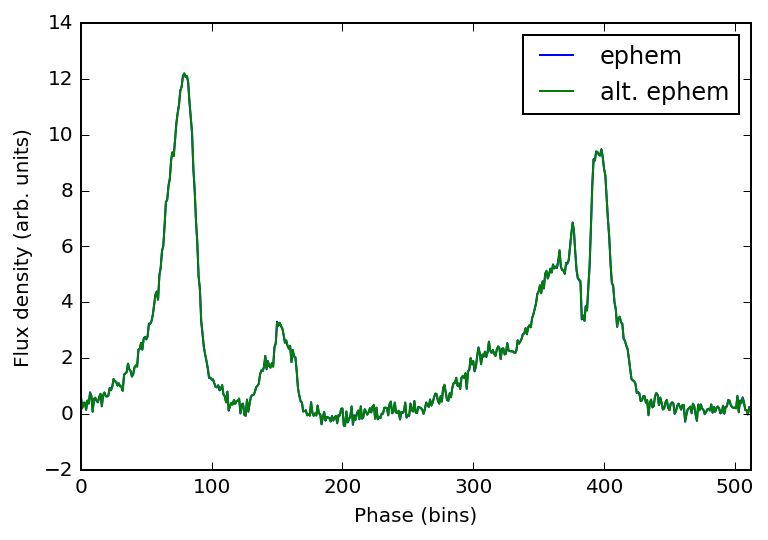

In [256]:
F = psrchive.Archive_load(test_file)
mjd = (F.get_Integration(0).get_start_time().in_days()
    +F.get_Integration(len(F)-1).get_end_time().in_days())/2
par = par_db.get_par_for(mjd)
G = pam_load(["-E", par], test_file)
G.fscrunch()
G.tscrunch()
G.pscrunch()
G.remove_baseline()
plt.plot(np.squeeze(G.get_data()), label="ephem")

par = par_db.get_par_for(mjd+4)
G = pam_load(["-E", par], test_file)
G.fscrunch()
G.tscrunch()
G.pscrunch()
G.remove_baseline()
plt.plot(np.squeeze(G.get_data()), label="alt. ephem")

plt.legend(loc="best")

plt.xlim(0,G.get_nbin())
plt.xlabel("Phase (bins)")
plt.ylabel("Flux density (arb. units)")

In [220]:
P = subprocess.Popen(["tempo", 
                 "-ZPSR=J0337+17",
                 "-ZSITE=3",
                 "-ZSTART=%f" % F.get_Integration(0).get_start_time().in_days(),
                 "-ZSPAN=3600",
                 "-ZTOBS=24",
                 "-f", par],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
out, err = P.communicate()
print out
print err
poly = polycos.polycos("J0337+17")

Read 24 polycos for PSR J0337+17


In [221]:
poly.TMIDs

array([ 56050.91348133,  56050.955148  ,  56050.99681467,  56051.03848133,
        56051.080148  ,  56051.12181467,  56051.16348133,  56051.205148  ,
        56051.24681467,  56051.28848133,  56051.330148  ,  56051.37181467,
        56051.41348133,  56051.455148  ,  56051.49681467,  56051.53848133,
        56051.580148  ,  56051.62181467,  56051.66348133,  56051.705148  ,
        56051.74681467,  56051.78848133,  56051.830148  ,  56051.87181467])

In [222]:
def get_polyco(mjd, par):
    P = subprocess.Popen(["tempo", 
                     "-ZPSR=J0337+17",
                     "-ZSITE=@",
                     "-ZSTART=%f" % (mjd-0.5),
                     "-ZSPAN=3600",
                     "-ZTOBS=24",
                     "-ZFREQ=99999",
                     "-f", par],
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE)
    out, err = P.communicate()
    print out
    print err
    return polycos.polycos("J0337+17")


In [223]:
par1 = par_db.get_par_for(mjd)
p1 = get_polyco(mjd, par1)

par2 = par_db.get_par_for(mjd-4)
p2 = get_polyco(mjd, par2)


Read 24 polycos for PSR J0337+17


Read 24 polycos for PSR J0337+17


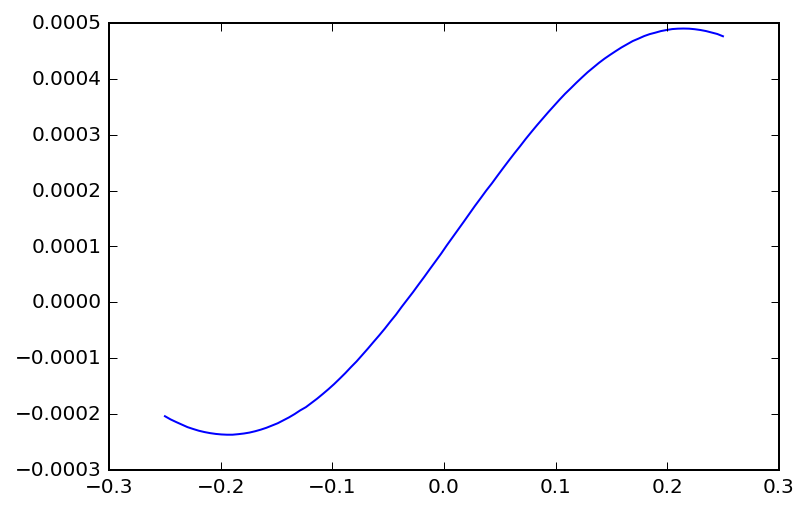

In [224]:
dphs = []
dts = np.linspace(-0.25,0.25,100)
for dt in dts:
    phs1, _ = p1.get_phs_and_freq(np.floor(mjd+dt), mjd+dt-np.floor(mjd+dt))
    phs2, _ = p2.get_phs_and_freq(np.floor(mjd+dt), mjd+dt-np.floor(mjd+dt))
    dphs.append((phs2-phs1+0.5)%1-0.5)
dphs = np.array(dphs)

plt.plot(dts, dphs)

In [225]:
import astropy
from astropy.time import Time

In [226]:
Time(56000, 0.1, format="mjd")

<Time object: scale='utc' format='mjd' value=56000.1>

In [227]:
def to_mjd(s):
    i,f = s.split(".")
    mjdi = float(i)
    mjdf = float("0."+f)
    return Time(mjdi, mjdf, format="mjd", scale="tdb")

to_mjd("56000.1")

<Time object: scale='tdb' format='mjd' value=56000.1>

In [228]:
timlines = open("fake.tim").readlines()
pulselines = open("fake.pulses").readlines()
mjds = [to_mjd(l.split()[2]) for l in timlines]
mtp = zip(mjds, timlines, pulselines)

mtp_l = [(m, t, p) for (m, t, p) in mtp if abs(m.mjd-mjd)<4]

In [229]:
t=to_mjd("56000.1")

In [230]:
t.mjd

56000.1

In [231]:
t.jd1

2456000.5

In [232]:
def to_i_f(t):
    i = t.jd1-2400000.5
    f = t.jd2
    return i,f

to_i_f(t)

(56000.0, 0.1)

In [233]:
mtp_l[0]

(<Time object: scale='tdb' format='mjd' value=56046.9073338>,
 '@             999999.999 56046.9073338471619     3.00\n',
 '-1678711491\n')

In [234]:
par_fit_name = "0337+17_MvK_forfit.par"
temp_tim = "temp.tim"
temp_pulses = "temp.pulses"
with open(temp_tim, "wt") as f:
    with open(temp_pulses, "wt") as g:
        for m,l,p in mtp_l:
            f.write(l)
            g.write(p)

shutil.copy(par_fit_name, "J0337+17.par")
for i in range(10):
    pipe.check_call(["tempo", "-f", "J0337+17.par", "-ni", temp_pulses, temp_tim])
    r = residuals.read_residuals()
    print np.std(r.prefit_sec), np.mean(r.postfit_phs)
shutil.copy("J0337+17.par", "shortterm.par")

3.7955577167e-05 -6.89012161128e-15
2.22841620482e-06 2.62689718068e-16
8.79078384482e-07 6.88722082837e-16
8.788910414e-07 1.54176693114e-15
8.78890945368e-07 -4.6436595888e-16
8.78891116071e-07 3.87969008048e-16
8.78890803155e-07 -2.40130994516e-16
8.7889161054e-07 -1.35082646024e-16
8.78890962038e-07 6.96026081822e-16
8.78890894617e-07 7.35815759451e-16


Read 24 polycos for PSR J0337+17


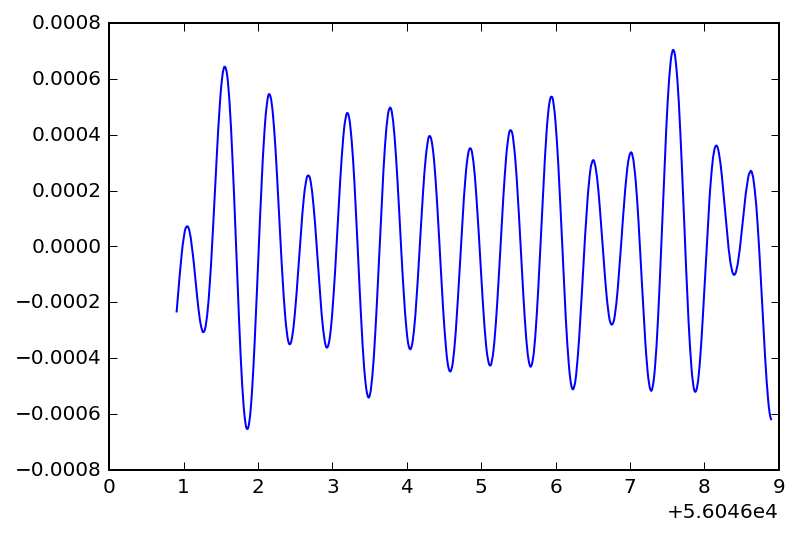

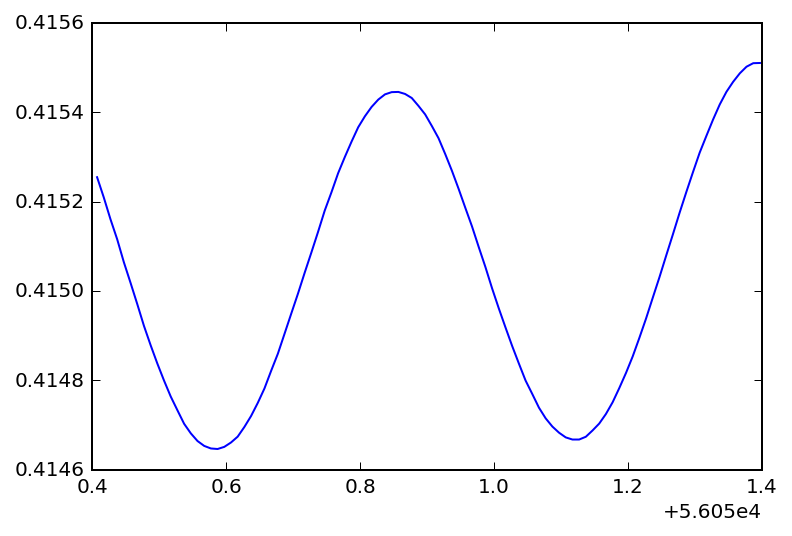

In [235]:
ps = get_polyco(mjd, "shortterm.par")
poly_phs = []
poly_mjd = []
for m, t, p in mtp_l:
    if abs(m.mjd-mjd)>0.5:
        continue
    i, f = to_i_f(m)
    poly_mjd.append(m.mjd)
    poly_phs.append(ps.get_phs_and_freq(i,f)[0])
plt.plot(r.bary_TOA, r.postfit_phs)
#plt.plot(poly_mjd, poly_phs, '.')
#plt.xlim(mjd-0.5,mjd+0.5)
plt.figure()
plt.plot(poly_mjd, poly_phs)


In [236]:
for l in open("shortterm.par").readlines():
    if l.startswith("TZRMJD"):
        tzrmjd_s = l.split()[1]
    elif l.startswith("TZRFRQ"):
        tzrfreq = float(l.split()[1])
    elif l.startswith("TZRSITE"):
        tzrsite = l.split()[1]
print tzrsite, tzrfreq, tzrmjd_s
abs_line = "@             999999.999 %19s     3.00\n" % tzrmjd_s[:19]

@ 999999.999 56100.00000000000000


In [237]:
print mtp_l[0][1].strip()
print abs_line.strip()


@             999999.999 56046.9073338471619     3.00
@             999999.999 56100.0000000000000     3.00


In [238]:
abs_tim = "abs.tim"
with open(abs_tim, "wt") as f:
    f.write(abs_line)
    for m,l,p in mtp_l:
        f.write(l)


0.0


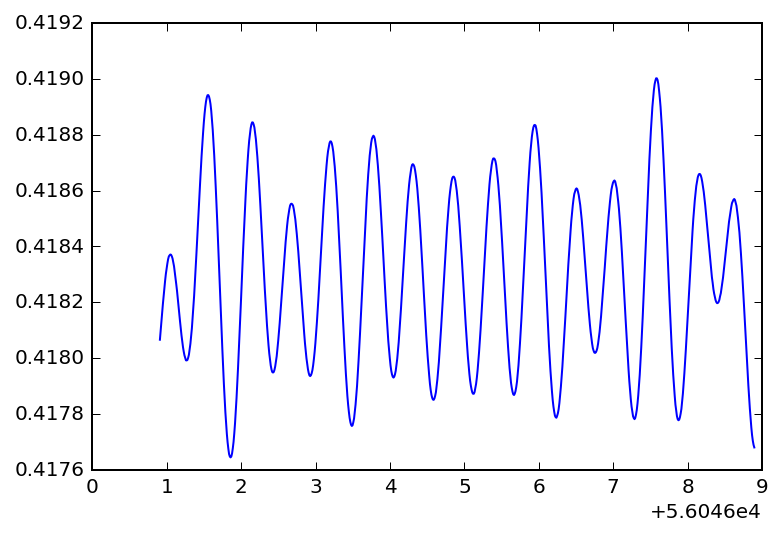

In [239]:
pipe.check_call(["tempo", "-f", "shortterm.par", abs_tim])
r = residuals.read_residuals()
print r.prefit_phs[0]
plt.plot(r.bary_TOA[1:], r.prefit_phs[1:])

In [250]:
pepoch_now = 56100
f1 = 3.459285698888e-16
pepoch_new = 55920
dt = 86400*(pepoch_now-pepoch_new)
df0 = -f1*dt
df0

-5.379881118910617e-09

In [252]:
6.437517366e-7 + df0

6.383718554810895e-07